BL40A2010 Introduction to IoT-Based Systems 

#### Final work, 02.02.2024

**Author: Jesse Peltola**

In [49]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### **Introduction**

In this work, I am going to find how adverse weather impacts the VR trains schedule.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx 
import numpy as np 
from graphql import GraphQLError, build_ast_schema, parse, print_schema, execute
import requests


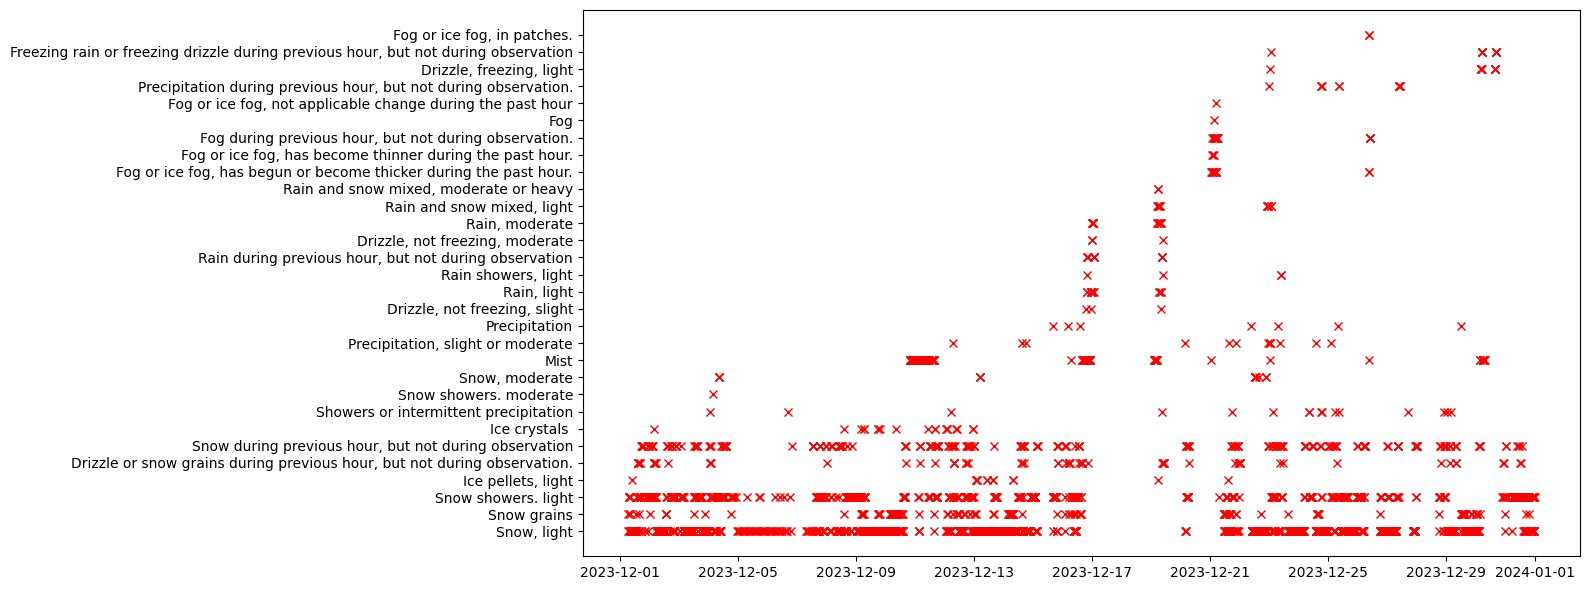

In [44]:


weather_condition = pd.read_csv("Tampere_harmala_2023_12_weather_condition.csv", dayfirst=True, sep=",", header=0,
                                decimal=b',', usecols=[0, 1, 2, 3, 4, 5])

weather_condition["Date"] = pd.to_datetime(weather_condition[['Year', 'Month', 'Day', 'Time [Local time]']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H:%M')
weather_condition.drop(['Observation station', 'Year', 'Month', 'Day', 'Time [Local time]'], axis=1, inplace=True)

for i in weather_condition['Weather description']:
    weather_condition = weather_condition[weather_condition['Weather description'] != 'No significant weather']

weather_condition.head()

plt.figure(figsize=(16, 6))
plt.plot(weather_condition['Date'], weather_condition['Weather description'], color="red", marker='x', linestyle='', label="Weather condition")
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Air temperature [°C]       4122 non-null   float64       
 1   Snow depth [cm]            4122 non-null   int64         
 2   Horizontal visibility [m]  4122 non-null   int64         
 3   Date                       4122 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 128.9 KB


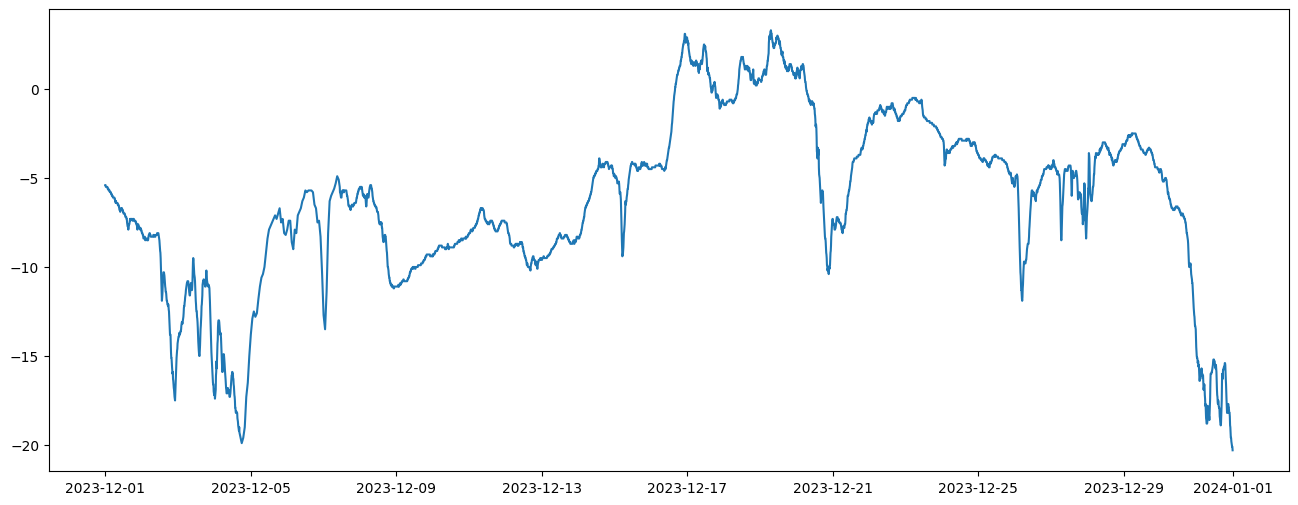

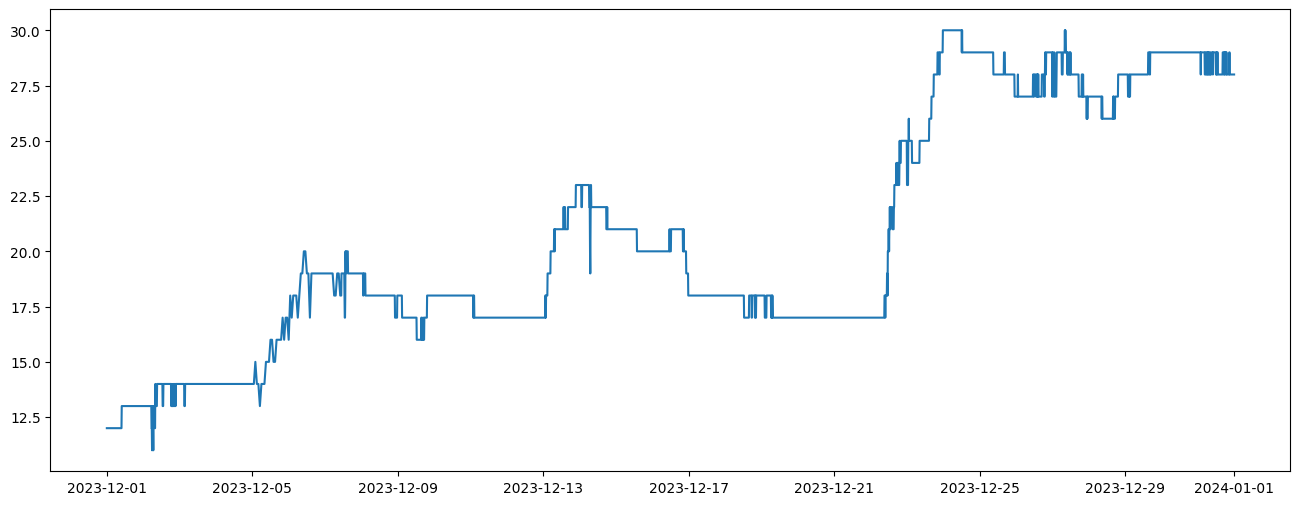

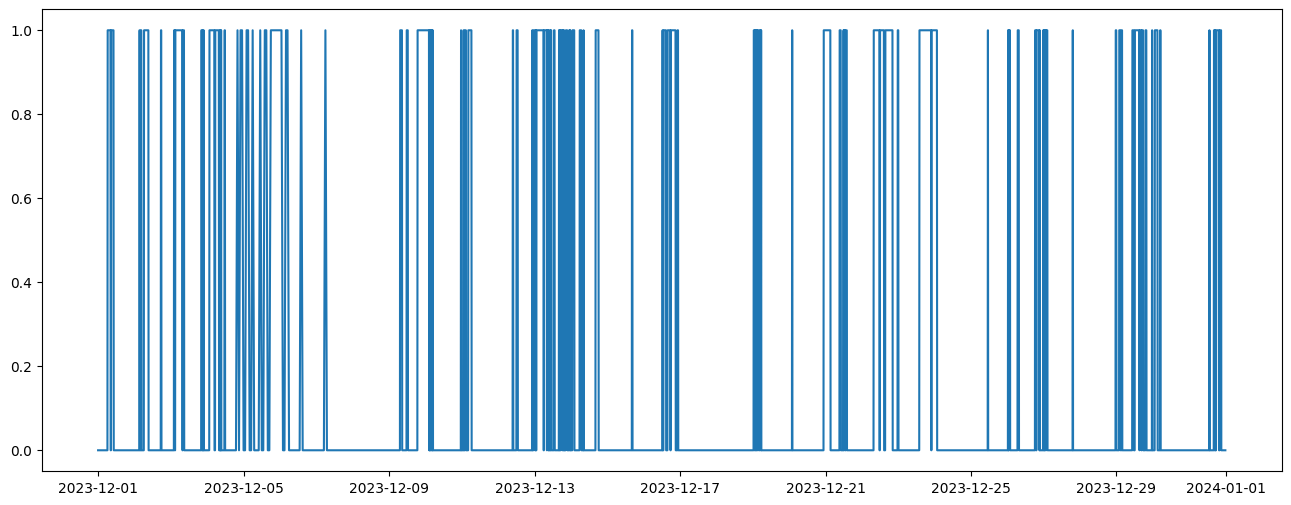

In [41]:
weather = pd.read_csv("Tampere_harmala_2023_12_weather.csv", dayfirst=True, sep=",", header=0,
                                decimal=b',', usecols=[0, 1, 2, 3, 4, 5, 6, 7])
weather["Date"] = pd.to_datetime(weather[['Year', 'Month', 'Day', 'Time [UTC]']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H:%M')
weather.drop(['Observation station', 'Year', 'Month', 'Day', 'Time [UTC]'], axis=1, inplace=True)

weather["Air temperature [°C]"] = pd.to_numeric(weather["Air temperature [°C]"], errors="coerce")
weather.info()

plt.figure(figsize=(16,6))
plt.plot(weather["Date"], weather['Air temperature [°C]'])
plt.show()
plt.figure(figsize=(16,6))
plt.plot(weather["Date"], weather['Snow depth [cm]'])
plt.show()
plt.figure(figsize=(16,6))
plt.plot(weather["Date"], weather["Horizontal visibility [m]"])
plt.show()

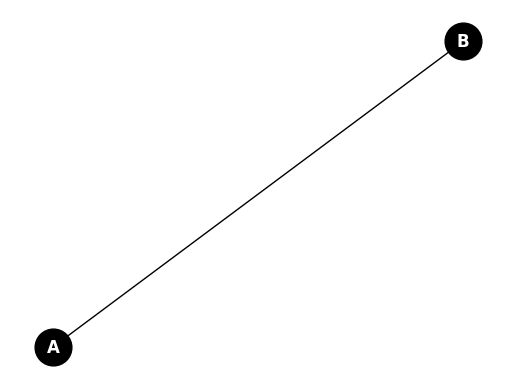

In [48]:
G1 = nx.Graph()

G1.add_nodes_from(["A", "B"])
G1.add_edge("A", "B")
nx.draw_networkx(G1, node_color='black', font_color='white', edge_color='black', font_weight='bold', node_size=700)
plt.axis('off')
plt.show()

In [58]:
from VR_queries import query1, query2
graphql_endpoint = graphql_endpoint = 'https://rata.digitraffic.fi/api/v2/graphql/graphql'
headers = {
    'Content-Type': 'application/json',
    'Accept-Encoding': 'gzip'
}



def make_graphql_request(query, endpoint, headers):
    try:
        # Make the GraphQL request with headers
        response = requests.post(endpoint, json={'query': query}, headers=headers)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse and print the response
            result = response.json()
            return result
        else:
            # Print an error message if the request was unsuccessful
            print(f"Error: {response.status_code} - {response.text}")

    except Exception as e:
        # Handle exceptions
        print(f"An error occurred: {e}")

# Make the GraphQL request with headers
tampere_data = make_graphql_request(query1, graphql_endpoint, headers)

{'data': {'trainsByDepartureDate': [{'timeTableRows': [{'scheduledTime': '2020-10-06T08:35:00.000Z', 'actualTime': '2020-10-06T08:35:25.000Z', 'differenceInMinutes': 0}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T03:23:00.000Z', 'actualTime': '2020-10-06T03:23:11.000Z', 'differenceInMinutes': 0}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T10:35:00.000Z', 'actualTime': '2020-10-06T10:36:24.000Z', 'differenceInMinutes': 1}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T05:24:00.000Z', 'actualTime': '2020-10-06T05:24:21.000Z', 'differenceInMinutes': 0}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T14:35:00.000Z', 'actualTime': '2020-10-06T14:35:15.000Z', 'differenceInMinutes': 0}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T09:24:00.000Z', 'actualTime': '2020-10-06T09:25:22.000Z', 'differenceInMinutes': 1}]}, {'timeTableRows': [{'scheduledTime': '2020-10-06T16:35:00.000Z', 'actualTime': '2020-10-06T16:36:47.000Z', 'differenceInMinutes': 2}]}, {'timeTableR

In [61]:
# main_code.py
import requests
import datetime, time
import json

graphql_endpoint = "https://rata.digitraffic.fi/api/v2/graphql/graphql"
headers = {"Content-Type": "application/json", "Accept-Encoding": "gzip"}

# Generate queries for each day in October 2020
queries_for_month = []
start_date = "2020-10-01"
end_date = "2020-10-31"

current_date = start_date
while current_date <= end_date:
    query_for_day = f"""
    {{
      trainsByDepartureDate(departureDate: "{current_date}",
        where: {{
          and: [
            {{ timeTableRows: {{ contains: {{ station: {{ shortCode: {{ equals: "HKI" }} }} }} }} }},
            {{ timeTableRows: {{ contains: {{ station: {{ shortCode: {{ equals: "TPE" }} }} }} }} }}
          ]
        }}) {{
        timeTableRows(where:{{station:{{name:{{equals: "Helsinki asema"}}}}
          ) {{
            scheduledTime
            actualTime
            differenceInMinutes
          }}
        }}
      }}
    }}
    """
    queries_for_month.append(query_for_day)

    # Move to the next day
    current_date = (datetime.datetime.strptime(current_date, "%Y-%m-%d") + datetime.timedelta(days=1)).strftime("%Y-%m-%d")

# Make GraphQL requests for each day in the month
results_for_month = []
for idx, query_for_day in enumerate(queries_for_month):
    try:
        # Make the GraphQL request with headers
        response = requests.post(graphql_endpoint, json={"query": query_for_day}, headers=headers)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse and append the response to the results list
            result_for_day = response.json()
            results_for_month.append(result_for_day)
        else:
            # Print an error message if the request was unsuccessful
            print(f"Error: {response.status_code} - {response.text}")

    except Exception as e:
        # Handle exceptions
        print(f"An error occurred: {e}")
    time.sleep(100)
# Process or print the results as needed
for idx, result_for_day in enumerate(results_for_month):
    print(f"Result for {start_date} + {idx} day:")
    print(result_for_day)

# Optionally, save the results to a JSON file
with open('results_for_month.json', 'w') as json_file:
    json.dump(results_for_month, json_file, indent=2)